In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error,r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = df = pd.read_csv("AAPL.csv")
df

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.0500,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.1000,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.9000,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.0500,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.3200,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.960,316.500,310.3241,313.17,33843125,314.960000,316.500000,310.324100,313.170000,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.140,318.520,313.0100,315.03,25432385,313.140000,318.520000,313.010000,315.030000,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.230,319.520,316.2000,316.68,27876215,319.230000,319.520000,316.200000,316.680000,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.850,320.890,315.8700,318.66,25672211,316.850000,320.890000,315.870000,318.660000,25672211,0.0,1.0


In [3]:
df.drop(["Unnamed: 0","symbol","adjHigh","adjLow","adjOpen","adjVolume","divCash","splitFactor"],axis=1,inplace=True)

In [4]:
df

,date,close,high,low,open,volume,adjClose
0,2015-05-27 00:00:00+00:00,132.045,132.260,130.0500,130.34,45833246,121.682558
1,2015-05-28 00:00:00+00:00,131.780,131.950,131.1000,131.86,30733309,121.438354
2,2015-05-29 00:00:00+00:00,130.280,131.450,129.9000,131.23,50884452,120.056069
3,2015-06-01 00:00:00+00:00,130.535,131.390,130.0500,131.20,32112797,120.291057
4,2015-06-02 00:00:00+00:00,129.960,130.655,129.3200,129.86,33667627,119.761181
...,...,...,...,...,...,...,...
1253,2020-05-18 00:00:00+00:00,314.960,316.500,310.3241,313.17,33843125,314.960000
1254,2020-05-19 00:00:00+00:00,313.140,318.520,313.0100,315.03,25432385,313.140000
1255,2020-05-20 00:00:00+00:00,319.230,319.520,316.2000,316.68,27876215,319.230000
1256,2020-05-21 00:00:00+00:00,316.850,320.890,315.8700,318.66,25672211,316.850000


In [6]:
df["date"] = pd.to_datetime(df["date"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   date      1258 non-null   datetime64[ns, UTC]
 1   close     1258 non-null   float64            
 2   high      1258 non-null   float64            
 3   low       1258 non-null   float64            
 4   open      1258 non-null   float64            
 5   volume    1258 non-null   int64              
 6   adjClose  1258 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 68.9 KB


In [8]:
df.set_index("date",inplace=True)

In [9]:
df

,close,high,low,open,volume,adjClose
date,,,,,,
2015-05-27 00:00:00+00:00,132.045,132.260,130.0500,130.34,45833246,121.682558
2015-05-28 00:00:00+00:00,131.780,131.950,131.1000,131.86,30733309,121.438354
2015-05-29 00:00:00+00:00,130.280,131.450,129.9000,131.23,50884452,120.056069
2015-06-01 00:00:00+00:00,130.535,131.390,130.0500,131.20,32112797,120.291057
2015-06-02 00:00:00+00:00,129.960,130.655,129.3200,129.86,33667627,119.761181
...,...,...,...,...,...,...
2020-05-18 00:00:00+00:00,314.960,316.500,310.3241,313.17,33843125,314.960000
2020-05-19 00:00:00+00:00,313.140,318.520,313.0100,315.03,25432385,313.140000
2020-05-20 00:00:00+00:00,319.230,319.520,316.2000,316.68,27876215,319.230000


In [10]:
df.index = df.index.date

In [11]:
df

,close,high,low,open,volume,adjClose
2015-05-27,132.045,132.260,130.0500,130.34,45833246,121.682558
2015-05-28,131.780,131.950,131.1000,131.86,30733309,121.438354
2015-05-29,130.280,131.450,129.9000,131.23,50884452,120.056069
2015-06-01,130.535,131.390,130.0500,131.20,32112797,120.291057
2015-06-02,129.960,130.655,129.3200,129.86,33667627,119.761181
...,...,...,...,...,...,...
2020-05-18,314.960,316.500,310.3241,313.17,33843125,314.960000
2020-05-19,313.140,318.520,313.0100,315.03,25432385,313.140000
2020-05-20,319.230,319.520,316.2000,316.68,27876215,319.230000
2020-05-21,316.850,320.890,315.8700,318.66,25672211,316.850000


In [12]:
df.index

Index([2015-05-27, 2015-05-28, 2015-05-29, 2015-06-01, 2015-06-02, 2015-06-03,
       2015-06-04, 2015-06-05, 2015-06-08, 2015-06-09,
       ...
       2020-05-11, 2020-05-12, 2020-05-13, 2020-05-14, 2020-05-15, 2020-05-18,
       2020-05-19, 2020-05-20, 2020-05-21, 2020-05-22],
      dtype='object', length=1258)

In [13]:
df.index = pd.to_datetime(df.index)

In [14]:
df.index

DatetimeIndex(['2015-05-27', '2015-05-28', '2015-05-29', '2015-06-01',
               '2015-06-02', '2015-06-03', '2015-06-04', '2015-06-05',
               '2015-06-08', '2015-06-09',
               ...
               '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22'],
              dtype='datetime64[ns]', length=1258, freq=None)

In [15]:
df

,close,high,low,open,volume,adjClose
2015-05-27,132.045,132.260,130.0500,130.34,45833246,121.682558
2015-05-28,131.780,131.950,131.1000,131.86,30733309,121.438354
2015-05-29,130.280,131.450,129.9000,131.23,50884452,120.056069
2015-06-01,130.535,131.390,130.0500,131.20,32112797,120.291057
2015-06-02,129.960,130.655,129.3200,129.86,33667627,119.761181
...,...,...,...,...,...,...
2020-05-18,314.960,316.500,310.3241,313.17,33843125,314.960000
2020-05-19,313.140,318.520,313.0100,315.03,25432385,313.140000
2020-05-20,319.230,319.520,316.2000,316.68,27876215,319.230000
2020-05-21,316.850,320.890,315.8700,318.66,25672211,316.850000


In [16]:
df["date"] = df.index

In [17]:
df

,close,high,low,open,volume,adjClose,date
2015-05-27,132.045,132.260,130.0500,130.34,45833246,121.682558,2015-05-27
2015-05-28,131.780,131.950,131.1000,131.86,30733309,121.438354,2015-05-28
2015-05-29,130.280,131.450,129.9000,131.23,50884452,120.056069,2015-05-29
2015-06-01,130.535,131.390,130.0500,131.20,32112797,120.291057,2015-06-01
2015-06-02,129.960,130.655,129.3200,129.86,33667627,119.761181,2015-06-02
...,...,...,...,...,...,...,...
2020-05-18,314.960,316.500,310.3241,313.17,33843125,314.960000,2020-05-18
2020-05-19,313.140,318.520,313.0100,315.03,25432385,313.140000,2020-05-19
2020-05-20,319.230,319.520,316.2000,316.68,27876215,319.230000,2020-05-20
2020-05-21,316.850,320.890,315.8700,318.66,25672211,316.850000,2020-05-21


In [18]:
full_date_range = pd.date_range(start=df.index.min(),end=df.index.max(),freq="D")

In [19]:
len(full_date_range)

1823

In [20]:
missing_values = full_date_range.difference(df.index)
missing_values
len(missing_values)

565

In [21]:
df = df.reindex(full_date_range)

In [22]:
df.ffill(inplace=True)

In [23]:
df.isna().sum()

close       0
high        0
low         0
open        0
volume      0
adjClose    0
date        0
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1823 entries, 2015-05-27 to 2020-05-22
Freq: D
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   close     1823 non-null   float64       
 1   high      1823 non-null   float64       
 2   low       1823 non-null   float64       
 3   open      1823 non-null   float64       
 4   volume    1823 non-null   float64       
 5   adjClose  1823 non-null   float64       
 6   date      1823 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 178.5 KB


In [25]:
df

,close,high,low,open,volume,adjClose,date
2015-05-27,132.045,132.26,130.0500,130.34,45833246.0,121.682558,2015-05-27
2015-05-28,131.780,131.95,131.1000,131.86,30733309.0,121.438354,2015-05-28
2015-05-29,130.280,131.45,129.9000,131.23,50884452.0,120.056069,2015-05-29
2015-05-30,130.280,131.45,129.9000,131.23,50884452.0,120.056069,2015-05-29
2015-05-31,130.280,131.45,129.9000,131.23,50884452.0,120.056069,2015-05-29
...,...,...,...,...,...,...,...
2020-05-18,314.960,316.50,310.3241,313.17,33843125.0,314.960000,2020-05-18
2020-05-19,313.140,318.52,313.0100,315.03,25432385.0,313.140000,2020-05-19
2020-05-20,319.230,319.52,316.2000,316.68,27876215.0,319.230000,2020-05-20
2020-05-21,316.850,320.89,315.8700,318.66,25672211.0,316.850000,2020-05-21


# LSTM

In [26]:
lstm_df = df[["high"]]
lstm_df

,high
2015-05-27,132.26
2015-05-28,131.95
2015-05-29,131.45
2015-05-30,131.45
2015-05-31,131.45
...,...
2020-05-18,316.50
2020-05-19,318.52
2020-05-20,319.52
2020-05-21,320.89


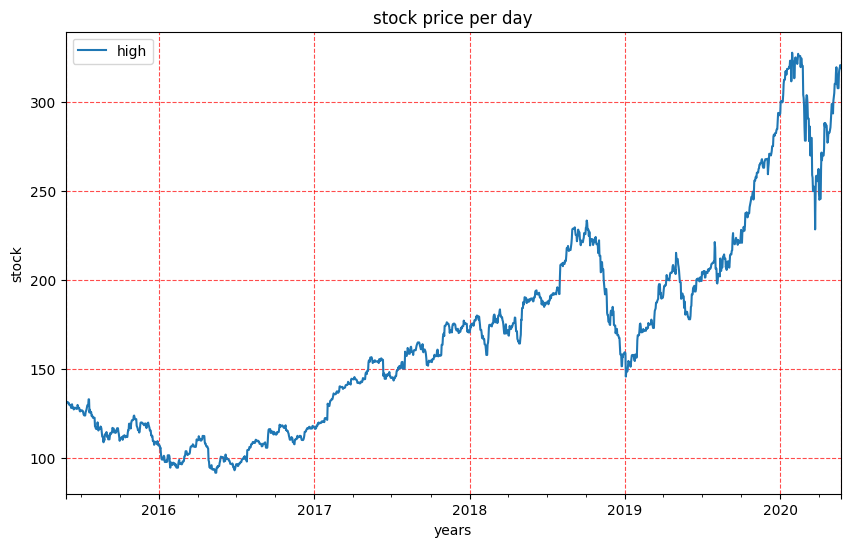

In [27]:
lstm_df.plot(figsize=(10,6),xlabel="years",ylabel="stock",title="stock price per day")
plt.grid(ls="--",c="r",alpha=0.7)
plt.show()

In [28]:
train = lstm_df[:len(lstm_df["high"])-365]
test = lstm_df[len(lstm_df["high"])-365:]
train.shape,test.shape

((1458, 1), (365, 1))

In [29]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler()

In [30]:
scaler.fit(train)
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.fit_transform(test)

In [32]:
generator = TimeseriesGenerator(scaled_train,scaled_train,length=20,batch_size=1)

In [31]:
generator[0]

(array([[[0.28624824],
         [0.28406206],
         [0.28053597],
         [0.28053597],
         [0.28053597],
         [0.28011283],
         [0.27492948],
         [0.27693935],
         [0.27440056],
         [0.26812412],
         [0.26812412],
         [0.26812412],
         [0.26473907],
         [0.2567701 ],
         [0.26565585],
         [0.27157969],
         [0.25853315],
         [0.25853315],
         [0.25853315],
         [0.25084626]]]),
 array([[0.2551481]]))

In [32]:
generator[0][0].shape

(1, 20, 1)

In [33]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=((20, 1))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(generator, epochs=20, verbose=1)



Epoch 1/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0112
Epoch 2/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0026
Epoch 3/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0019
Epoch 4/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0017
Epoch 5/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0017
Epoch 6/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0020
Epoch 7/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0016
Epoch 8/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0018
Epoch 9/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0013
Epoch 10/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0014
Epoch 11/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0013
Epoch 12/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0015
Epoch 13/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0013
Epoch 14/20
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0014
Epoch 15/20

# prediction of stocks on testing data

345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


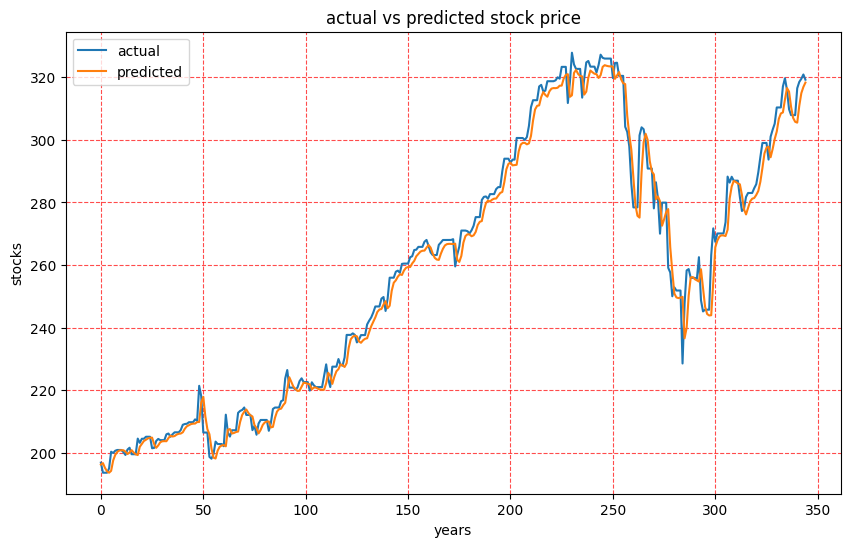

lstm_rmse =  4.968425215073765
y_test_mean =  254.44041424657533


In [34]:
# Use TimeSeriesGenerator for test data
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=20, batch_size=1)

# Predict using LSTM model
predictions = model.predict(test_generator)

predictions = scaler.inverse_transform(predictions)
actual_test = scaler.inverse_transform(scaled_test[20:])

# creating graph of actual vs predicted stock price
plt.figure(figsize=(10,6))
plt.plot(actual_test,label="actual")
plt.plot(predictions,label="predicted")
plt.legend()
plt.grid(ls="--",alpha=0.7,c="r")
plt.xlabel("years")
plt.ylabel("stocks")
plt.title("actual vs predicted stock price")
plt.show()

# find out rmse score
rmse = np.sqrt(mean_squared_error(actual_test,predictions))
print("lstm_rmse = ",rmse)
print("y_test_mean = ",test["high"].mean())

# prediction of stocks of next 365 days

In [35]:
scaled_lstm_df = scaler.fit_transform(lstm_df)
scaled_lstm_df

array([[0.17186045],
       [0.17054789],
       [0.16843086],
       ...,
       [0.96473029],
       [0.97053095],
       [0.96350241]])

In [36]:
generator = TimeseriesGenerator(scaled_lstm_df,scaled_lstm_df,length=30,batch_size=1)

In [37]:
generator[0][0].shape

(1, 30, 1)

In [38]:
generator[0]

(array([[[0.17186045],
         [0.17054789],
         [0.16843086],
         [0.16843086],
         [0.16843086],
         [0.16817681],
         [0.16506478],
         [0.16627149],
         [0.16474723],
         [0.16097891],
         [0.16097891],
         [0.16097891],
         [0.15894657],
         [0.15416208],
         [0.15949699],
         [0.1630536 ],
         [0.15522059],
         [0.15522059],
         [0.15522059],
         [0.15060547],
         [0.15318825],
         [0.15331527],
         [0.15513591],
         [0.15306122],
         [0.15306122],
         [0.15306122],
         [0.1540774 ],
         [0.15217207],
         [0.16144466],
         [0.15890423]]]),
 array([[0.15378101]]))

In [39]:
model = Sequential([
    LSTM(100, activation="relu", return_sequences=True, input_shape=(30,1)),  # Keep return_sequences=True for stacking
    Dropout(0.2),
    LSTM(50, activation="relu", return_sequences=False),  # Last LSTM keeps return_sequences=False
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)
])

In [40]:
model.compile(optimizer="adam",loss="mean_squared_error")
history = model.fit(generator,epochs=10)

Epoch 1/10
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0127
Epoch 2/10
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0024
Epoch 3/10
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0018
Epoch 4/10
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.0015
Epoch 5/10
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.0013
Epoch 6/10
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0014
Epoch 7/10
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0016
Epoch 8/10
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0011
Epoch 9/10
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0013
Epoch 10/10
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 9.4692e-04


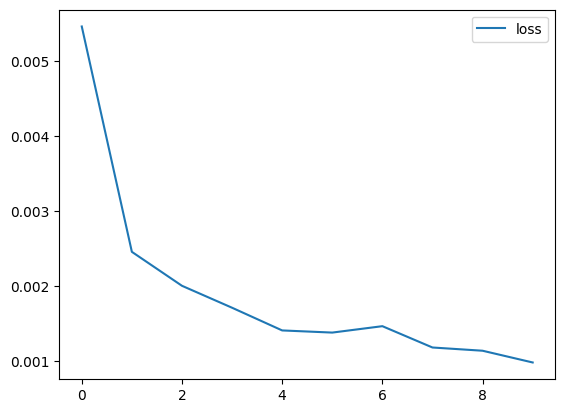

In [41]:
plt.plot(history.history["loss"],label="loss")
plt.legend()
plt.show()

In [42]:
current_batch = scaled_lstm_df[-30:]
current_batch = current_batch.reshape(1,30,1)
print("length: ",len(current_batch))
print("shape: ",current_batch.shape)

length:  1
shape:  (1, 30, 1)


In [43]:
pred = model.predict(current_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


In [44]:
pred

array([[0.97248715]], dtype=float32)

In [45]:
current_batch

array([[[0.80480989],
        [0.8101448 ],
        [0.8101448 ],
        [0.8101448 ],
        [0.81662291],
        [0.82208485],
        [0.83834364],
        [0.85892116],
        [0.8778474 ],
        [0.8778474 ],
        [0.8778474 ],
        [0.85536455],
        [0.88631552],
        [0.89579981],
        [0.90397155],
        [0.92590397],
        [0.92590397],
        [0.92590397],
        [0.95427217],
        [0.96544161],
        [0.9496147 ],
        [0.9235329 ],
        [0.91553053],
        [0.91553053],
        [0.91553053],
        [0.95194343],
        [0.96049623],
        [0.96473029],
        [0.97053095],
        [0.96350241]]])

In [46]:
prediction = []
current_batch = current_batch

In [47]:
for i in range(365):
    pred = model.predict(current_batch)[0]
    prediction.append(pred)

    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

In [48]:
lstm_future_df = scaler.inverse_transform(prediction)

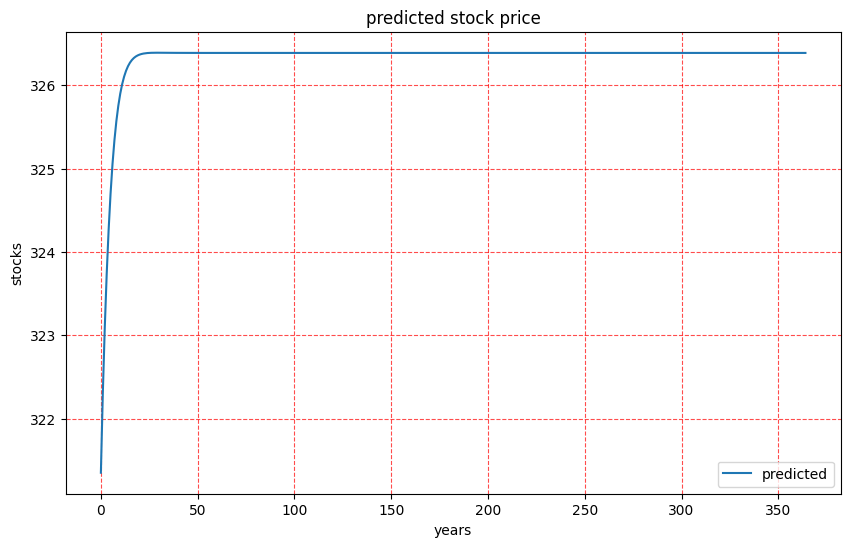

In [52]:
# creating graph of predicted stock price
plt.figure(figsize=(10,6))
plt.plot(lstm_future_df,label="predicted")
plt.legend()
plt.grid(ls="--",alpha=0.7,c="r")
plt.xlabel("years")
plt.ylabel("stocks")
plt.title("predicted stock price")
plt.show()


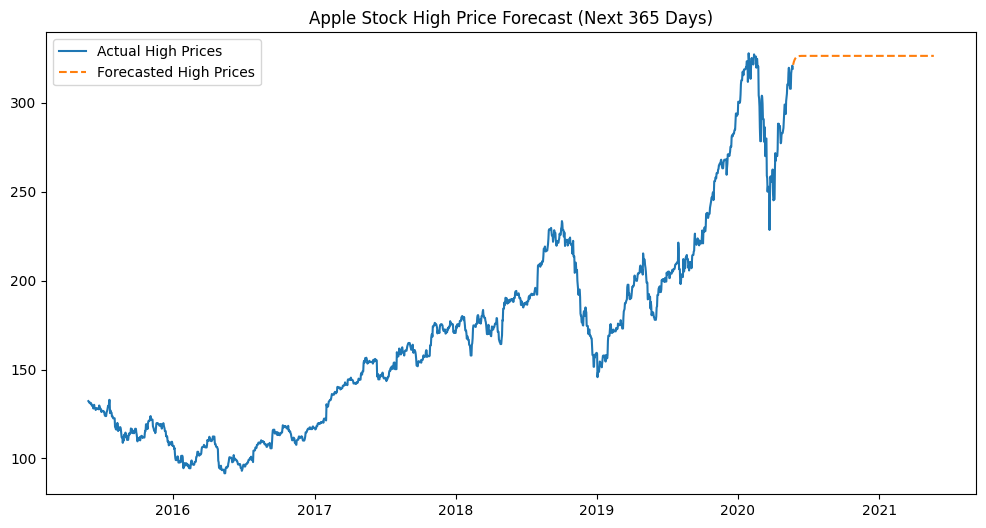

In [51]:
# making future dates for predicted values
future_dates = pd.date_range(start=lstm_df.index[-1] + pd.Timedelta(days=1), periods=365)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(lstm_df.index, lstm_df, label="Actual High Prices")
plt.plot(future_dates, lstm_future_df, label="Forecasted High Prices", linestyle='dashed')
plt.legend()
plt.title("Apple Stock High Price Forecast (Next 365 Days)")
plt.show()
